In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
import models.ddpm
import models.mlp
# from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP6dim, SpectralNormMLP


from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import torch

from typing import Tuple, Optional
import torch
from functorch import vmap


from functools import partial


import torchsde
import chex
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.scipy.stats import multivariate_normal
import blackjax
import blackjax.smc.resampling as resampling
from typing import Callable


from torchdiffeq import odeint
from torch.func import jacrev

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cuda
gpu


### Target Distribution

In [3]:
def get_senders_and_receivers_fully_connected(n_nodes):
    receivers = []
    senders = []
    for i in range(n_nodes):
        for j in range(n_nodes - 1):
            receivers.append(i)
            senders.append((i + 1 + j) % n_nodes)
    return torch.tensor(senders), torch.tensor(receivers)

def energy(x, epsilon= 1.0, tau= 1.0, r= 1.0, harmonic_potential_coef= 0.5):
    n_nodes, dim = x.shape
    
    if isinstance(r, float):
        r = torch.ones(n_nodes, device=device) * r
    senders, receivers = get_senders_and_receivers_fully_connected(n_nodes)
    vectors = x[senders] - x[receivers]
    d = torch.linalg.norm(vectors, ord=2, dim=-1)
    term_inside_sum = (r[receivers] / d)**12 - 2*(r[receivers] / d)**6
    energy = epsilon / (2 * tau) * term_inside_sum.sum()

    centre_of_mass = x.mean(dim=0)
    harmonic_potential = harmonic_potential_coef * (x - centre_of_mass).pow(2).sum()
    return energy + harmonic_potential


def log_prob(x: torch.Tensor):
    x = x.reshape(-1, 13, 3)
    if len(x.shape) == 2:
        return - energy(x)
    elif len(x.shape) == 3:
        return - torch.vmap(energy)(x)
    else:
        raise Exception

In [4]:
def interatomic_dist(samples):
    # Compute the pairwise differences and distances
    dist = samples[:, None, :, :] - samples[:, :, None, :]
    differences = torch.linalg.norm(dist, dim=-1)
    return differences #torch.mean(differences, dim=(1, 2))

In [5]:
def plot_sample_hist(samples, ax = None, dim=(0,1), label=None):
    if ax == None:
        fig, ax = plt.subplots()
    d = interatomic_dist(samples)
    ax.hist(d, bins=50, density=True, alpha=0.4, label=label)

### Helper Functions

In [6]:
def normalize(x):
    return x

def unnormalize(x, mins, maxs):
    return x

In [7]:
def safe_norm(x: jnp.ndarray, axis: int = None, keepdims=False) -> jnp.ndarray:
    """nan-safe norm. Copied from mace-jax"""
    x2 = jnp.sum(x**2, axis=axis, keepdims=keepdims)
    return jnp.where(x2 == 0, 1, x2) ** 0.5

In [8]:
def energy_jax(x: chex.Array, epsilon: float = 1.0, tau: float = 1.0, r: Union[float, chex.Array] = 1.0,
           harmonic_potential_coef: float = 0.5) -> chex.Array:
    chex.assert_rank(x, 2)
    n_nodes, dim = x.shape
    if isinstance(r, float):
        r = jnp.ones(n_nodes) * r
    senders, receivers = get_senders_and_receivers_fully_connected(n_nodes)
    senders, receivers = jnp.array(senders), jnp.array(receivers)
    vectors = x[senders] - x[receivers]
    d = safe_norm(vectors, axis=-1)
    term_inside_sum = (r[receivers] / d)**12 - 2*(r[receivers] / d)**6
    energy = epsilon / (2 * tau) * jnp.sum(term_inside_sum)

    # For harmonic potential see https://github.com/vgsatorras/en_flows/blob/main/deprecated/eqnode/test_systems.py#L94.
    # This oscillator is mentioned but not explicity specified in the paper where it was introduced:
    # http://proceedings.mlr.press/v119/kohler20a/kohler20a.pdf.
    centre_of_mass = jnp.mean(x, axis=0)
    harmonic_potential = harmonic_potential_coef*jnp.sum((x - centre_of_mass)**2)
    return energy + harmonic_potential


def log_prob_jax(x: chex.Array):
    if len(x.shape) == 2:
        return - energy_jax(x)
    elif len(x.shape) == 3:
        return - jax.vmap(energy_jax)(x)
    else:
        raise Exception

In [9]:
def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """Run the temepered SMC algorithm.

    We run the adaptive algorithm until the tempering parameter lambda reaches the value
    lambda=1.

    """

    def cond(carry):
        i, state, _k = carry
        return state.lmbda < 1

    def one_step(carry):
        i, state, k = carry
        k, subk = jax.random.split(k, 2)
        state, _ = smc_kernel(subk, state)
        return i + 1, state, k

    n_iter, final_state, _ = jax.lax.while_loop(
        cond, one_step, (0, initial_state, rng_key)
    )

    return n_iter, final_state

def prior_log_prob(x: chex.Array, scale: float = 1.):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d)*scale)

def run_smc_molecule(
        target_log_prob: Callable,
        key: chex.PRNGKey,
        dim: int,
        n_nodes: int,
        n_samples: int,
        num_mcmc_steps: int,
        base_scale: float = 1.,
        target_ess: float = 0.5,
        hmc_step_size: float = 1e-4):
    def flatten(x: chex.Array) -> chex.Array:
        return jnp.reshape(x, (*x.shape[:-2], dim*n_nodes))

    def unflatten(x: chex.Array) -> chex.Array:
        return jnp.reshape(x, (*x.shape[:-1], n_nodes, dim))

    def flat_log_prob_fn(x: chex.Array) -> chex.Array:
        """Takes in flat x."""
        return target_log_prob(unflatten(x))

    flat_dim = dim * n_nodes
    smc_samples = run_smc(
        flat_log_prob_fn,
        key,
        flat_dim,
        n_samples,
        num_mcmc_steps,
        target_ess=target_ess,
        base_scale=base_scale,
        hmc_step_size=hmc_step_size)

    samples = unflatten(smc_samples.particles)
    return samples, smc_samples.weights, smc_samples.lmbda


def run_smc(
        target_log_prob: Callable,
        key: chex.PRNGKey,
        dim: int,
        n_samples: int,
        num_mcmc_steps: int,
        base_scale: float = 1.,
        target_ess: float = 0.5,
        hmc_step_size: float = 1e-4):

    inv_mass_matrix = jnp.eye(dim)

    hmc_parameters = dict(
        step_size=hmc_step_size, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=1
    )

    base_log_prob = partial(prior_log_prob, scale=base_scale)
    tempered = blackjax.adaptive_tempered_smc(
        base_log_prob,
        target_log_prob,
        blackjax.hmc.build_kernel(),
        blackjax.hmc.init,
        hmc_parameters,
        resampling_fn=resampling.systematic,
        target_ess=target_ess,
        num_mcmc_steps=num_mcmc_steps,
    )

    initial_smc_state = jax.random.multivariate_normal(
        jax.random.PRNGKey(0), jnp.zeros([dim,]), jnp.eye(dim), (n_samples,)
    ) * base_scale
    initial_smc_state = tempered.init(initial_smc_state)

    n_iter, smc_samples = smc_inference_loop(key, tempered.step, initial_smc_state)
    return smc_samples

## Function Definitions

### Estimated Reward Functions

In [10]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, beta, num_mc_samples, global_mins=-3, global_maxs=3, var_exploding=True):
    h_t = beta * _t.repeat_interleave(num_mc_samples).unsqueeze(1)
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = beta * repeated_t
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = (repeated_x/torch.sqrt(1 - repeated_t.unsqueeze(1)) 
                   + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5))
        log_rewards = log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = torch.log(1 / (1 - _t)) + torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [11]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, randomness='different', 
                      in_dims=(0,0,None,None))(x, t, beta, num_mc_samples, var_exploding=var_exploding)

In [12]:
def estimate_grad_Rt(x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False):
    est_scores_n = torch.vmap(torch.func.grad(log_E_R), 
                            in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples, 
                                                                                  var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.vmap(torch.func.grad(log_E_R), 
                                   in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples//2, 
                                                                                         var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

### True Reward Functions

In [13]:
def true_Rt(x, t, beta, global_mins=-3, global_maxs=3, var_exploding=True):
    h_t = beta * t
    target.convolve(h_t * (global_maxs **2), t, var_exploding=var_exploding)
    energy = target.log_prob(unnormalize(x, global_mins, global_maxs))
    target.reset()
    return energy

In [14]:
def true_grad_Rt(x, t, beta, var_exploding=True):
    samples_energy = true_Rt(x, t, beta, var_exploding=var_exploding)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores

## SDE Tests

### Dataset

In [15]:
beta = 5

n_nodes = 13
dim = 3

n_samples = 1024

In [16]:
centers = torch.zeros((n_samples, n_nodes*dim), device=device)
x1_samples = torch.normal(centers, torch.full_like(centers, fill_value=beta))

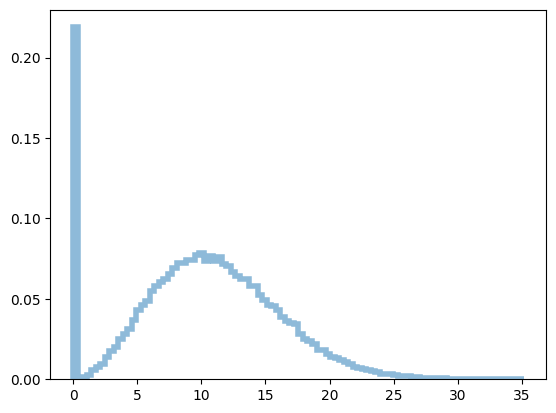

In [15]:
x1_dists = interatomic_dist(x1_samples.reshape(-1, n_nodes, dim))
plt.hist(x1_dists.view(-1).cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4)
plt.show()

In [18]:
# np load
# samples_all = np.load('all_data_LJ13.npy')
# samples_all = samples_all.reshape(-1, n_nodes, dim)
# samples_true = torch.tensor(samples_all[:1000], device=device)
# samples_all = sample_from_array(samples_all, n_samples)
# samples_true = torch.tensor(samples_all, device=device)
# del samples_all

In [16]:
def sample_from_array(array, size):
    idx = np.random.choice(array.shape[0], size=size)
    return array[idx]

In [17]:
samples_all_2 = np.load('all_data_LJ13-2.npy')
data_holdout = samples_all_2[len(samples_all_2)//2:]
data_holdout = sample_from_array(data_holdout, 1000)
del samples_all_2
data_holdout = torch.tensor(data_holdout, device=device)

In [14]:
def remove_mean(samples, n_particles, n_dimensions):
    """
    Makes a configuration of many particle system mean-free.

    Parameters
    ----------
    samples : torch.Tensor
        Positions of n_particles in n_dimensions.

    Returns
    -------
    samples : torch.Tensor
        Mean-free positions of n_particles in n_dimensions.
    """

    shape = samples.shape
    if isinstance(samples, torch.Tensor):
        samples = samples.view(-1, n_particles, n_dimensions)
        samples = samples - torch.mean(samples, dim=1, keepdim=True)
        samples = samples.view(*shape)
    else:
        samples = samples.reshape(-1, n_particles, n_dimensions)
        samples = samples - samples.mean(axis=1, keepdims=True)
        samples = samples.reshape(*shape)
    return samples

In [36]:
data_holdout = remove_mean(data_holdout, n_nodes, dim)

In [42]:
dist = interatomic_dist(data_holdout.reshape(-1, n_nodes, dim))
# dist_2 = interatomic_dist(samples_true)

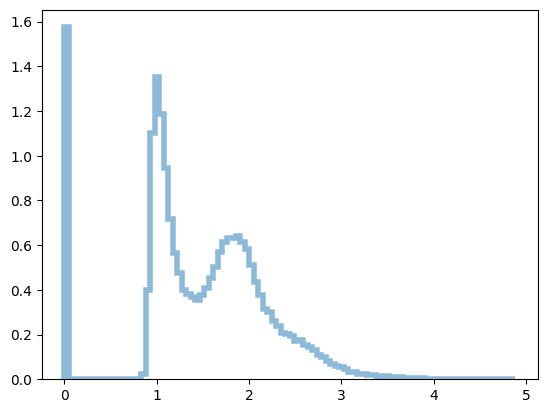

In [43]:
plt.hist(dist.view(-1).cpu(), bins=100, label="holdout samples", alpha=0.5, density=True, histtype='step', linewidth=4)
# plt.hist(dist_2.view(-1).cpu(), bins=100, label="true samples", alpha=0.5, density=True, histtype='step', linewidth=4)
plt.show()

In [36]:
# plot_sample_hist(torch.tensor(samples_all, device=device).reshape(-1, n_nodes, dim).detach().cpu())
# plot_sample_hist(torch.tensor(samples_all_2, device=device).reshape(-1, n_nodes, dim).detach().cpu())
# del samples_all

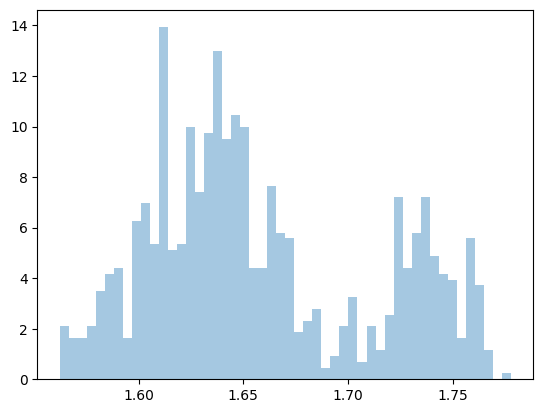

In [29]:
plot_sample_hist(samples_true.cpu())

### VE SDE

In [34]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta
    
    def f(self, t, x):
        x.requires_grad = True
        score = torch.vmap(self.score, randomness="different", in_dims=(0, None, None))(x, 1-t, self.beta, num_mc_samples=100)
        # norm = torch.linalg.vector_norm(score, dim=-1)
        # max_norm = 100
        # clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
        return self.g(t, x)**2 * score # * clip_coef[:,None]

    def g(self, t, x):
        return torch.full_like(x, self.beta ** 0.5)

In [35]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    drift = sde.f(t, x) * dt
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    vectors = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            vectors.append(f)
    return torch.stack(samples), torch.stack(vectors)

In [36]:
def estimate_grad_Rt(x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False):
    est_scores_n = torch.func.grad(log_E_R)(x, t, beta, num_mc_samples, var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(x, t, beta, num_mc_samples//2, var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

In [54]:
true_samples_pred = true_samples_pred[-1]

In [37]:
def generate_samples(ve_reverse_sde, x_init):
    t = torch.linspace(0.001, 0.99, 500).to(device)
    with torch.no_grad():
        samples = torchsde.sdeint(ve_reverse_sde, x_init, t, method='euler')
    return samples

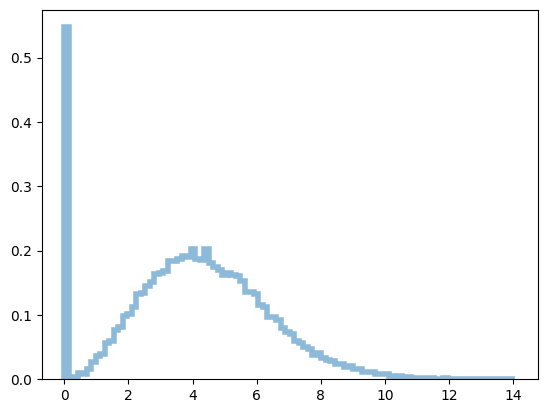

In [37]:
beta = 2
n_samples = 500
centers = torch.zeros((n_samples, n_nodes*dim), device=device)
x1_samples = torch.normal(centers, torch.full_like(centers, fill_value=beta))
x1_dists = interatomic_dist(x1_samples.reshape(-1, n_nodes, dim))
plt.hist(x1_dists.view(-1).cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4)
plt.show()

In [38]:
ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, beta)

In [39]:
# samples_pred = generate_samples(ve_reverse_sde, x1_samples)
samples_pred, pred_vectors = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 1e-3)

In [40]:
dist_pred = interatomic_dist(samples_pred[-1].reshape(-1, n_nodes, dim))

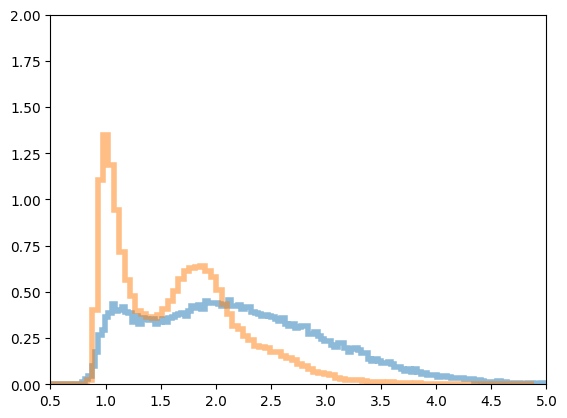

In [44]:
plt.hist(dist_pred.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True, histtype='step', linewidth=4)
plt.hist(dist.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4) 
plt.xlim(0.5, 5)
plt.ylim(0, 2)
plt.show()

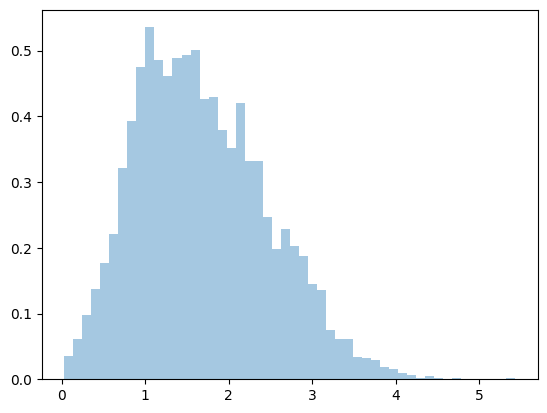

In [31]:
plot_sample_hist(samples_pred[-1].reshape(-1, n_nodes, dim).detach().cpu())
# plt.xlim(-0.25, 2.5)

### Comaprison

In [32]:
key = jax.random.PRNGKey(0)

smc_samples, weights, lmbda = run_smc_molecule(target_log_prob=log_prob_jax, dim=3, n_nodes=13, n_samples=n_samples, key=key, 
                      num_mcmc_steps=1000, base_scale = 1., hmc_step_size= 1e-3, target_ess=0.0)
smc_samples = torch.from_numpy(np.array(smc_samples))
print(smc_samples.shape)

torch.Size([4096, 13, 3])


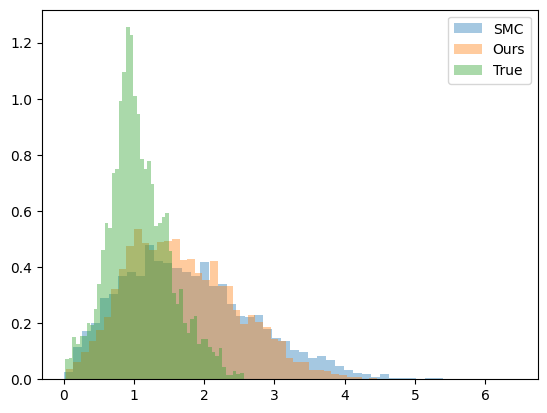

In [33]:
fig, ax = plt.subplots()
plot_sample_hist(smc_samples, ax=ax, label='SMC')
plot_sample_hist(samples_pred[-1].reshape(-1, n_nodes, dim).detach().cpu(), ax=ax, label='Ours')
plot_sample_hist(samples_all.cpu(), ax=ax, label='True')
plt.legend()
plt.show()

In [54]:
smc_log_prob = log_prob(smc_samples.to(device)).cpu().abs()
pred_log_prob = log_prob(samples_pred[-1].reshape(-1, n_nodes, dim).detach()).cpu().abs()
samples_true_log_prob = log_prob(samples_all).detach().cpu().abs()

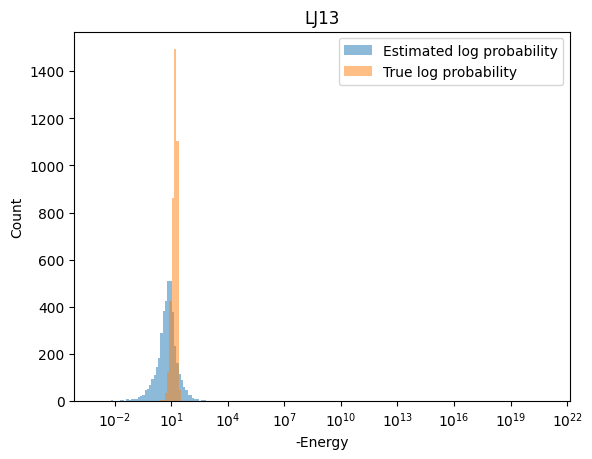

In [69]:
xmin = min(smc_log_prob.min(), pred_log_prob.min(), samples_true_log_prob.min())
xmax = max(smc_log_prob.max(), pred_log_prob.max(), samples_true_log_prob.max())


plt.hist(
    pred_log_prob.abs(),
    alpha=0.5,
    bins=np.logspace(np.log(xmin), np.log(xmax), num=200, base=np.e),
    label='Estimated log probability',
)
# plt.hist(
#     smc_log_prob.abs(), 
#     alpha=0.5, 
#     bins=np.logspace(np.log(smc_log_prob.abs().min()), np.log(smc_log_prob.abs().max()),num=100, base=np.e), 
#     label='SMC',
# )
plt.hist(
    samples_true_log_prob.abs(), 
    alpha=0.5, 
    bins=np.logspace(np.log(xmin), np.log(xmax), num=200, base=np.e), 
    label='True log probability',
)

plt.xscale('log')
plt.ylabel('Count')
plt.xlabel('-Energy')
plt.title('LJ13')
plt.legend()

plt.show()

###  NLL

In [18]:
def estimate_grad_Rt(x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False):
    est_scores_n = torch.func.grad(log_E_R)(x, t, beta, num_mc_samples, var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(x, t, beta, num_mc_samples//2, var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

In [19]:
def drift(x, t):
    with torch.enable_grad():
        x.requires_grad = True
        if follow_estimate:
            f = -0.5 * beta * estimate_grad_Rt(x, t, beta, num_mc_samples=100)
            norm = torch.linalg.vector_norm(f, dim=-1)
            #print(norm.max())
            max_norm = 10
            clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
            f = f * clip_coef.unsqueeze(-1)
        else:
            f = - 0.5 * beta * true_grad_Rt(x, t, beta)
        
    return f

In [20]:
def prior_dist(beta):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(39).to(device), torch.eye(39).to(device) * beta
    )
    return dist

In [45]:
sigma = np.sqrt(2)
beta = sigma ** 2

follow_estimate = True
reverse_time = True

In [22]:
# def drift(t, x):
#     f = 0.5 * beta * estimate_grad_Rt(x, t, beta, num_mc_samples=200)
#     norm = torch.linalg.vector_norm(f, dim=-1)
#     max_norm = 100
#     clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
#     return f * clip_coef

In [46]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    return lambda x: torch.trace(J(x))

def output_and_div(vecfield, x):
    if follow_estimate:
        dx = torch.vmap(vecfield, randomness="different")(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x)
    else:
        dx = vecfield(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x.clone().detach().requires_grad_(True))
    return dx, div

In [47]:
def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)
    vecfield = lambda x: drift(x, t)
    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)

with torch.no_grad():
    if reverse_time:
        x1 = torch.randn(1024, 39).to(device) * sigma
        time = torch.linspace(1, 0, 100).to(device)
    else:
        x1 = data_holdout
        time = torch.linspace(0, 1, 100).to(device)
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    state0 = odeint(odefunc, state1, t=time, method="euler")[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]
    p0 = prior_dist(beta)
    logp0 = p0.log_prob(x0)
    logp1 = -(logp0 + logdetjac)

In [25]:
p0 = prior_dist(beta)
logp0 = p0.log_prob(x0)
logp1 = -(logp0 + logdetjac)

In [26]:
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())

logp0 tensor(-57.5762, device='cuda:0')
logdetjac tensor(22.9004, device='cuda:0')
logp1 tensor(34.6758, device='cuda:0')


In [29]:
x0 = x0.reshape(-1, n_nodes, dim)

In [52]:
dist_pred = interatomic_dist(x0.reshape(-1, n_nodes, dim))

In [53]:
dist_pred.shape

torch.Size([1024, 13, 13])

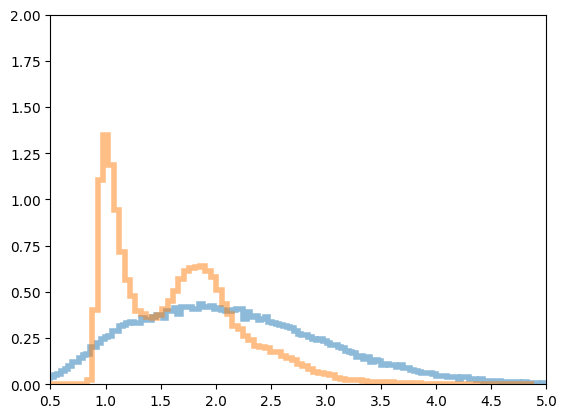

In [54]:
plt.hist(dist_pred.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True, histtype='step', linewidth=4)
plt.hist(dist.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4) 
plt.xlim(0.5, 5)
plt.ylim(0, 2)
plt.show()

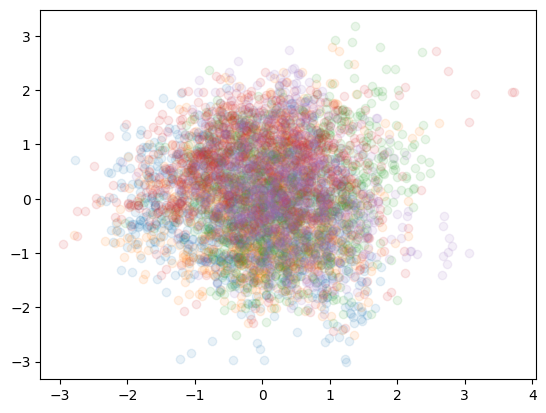

In [30]:
for i in range(5):
    plt.scatter(x0[:, i, 0].detach().cpu(), x0[:, i, 1].detach().cpu(), alpha=0.1)


### Training

In [39]:
def reward_matching_loss_biased(vectorfield, x, t, beta):     
    t = t.unsqueeze(1)
    h_t = beta * t
    # pdb.set_trace()?
    x.requires_grad = True

    # noisy sample: x(t)
    noisy_x = torch.normal(x, h_t ** 0.5)
    pred_scores = vectorfield(noisy_x, t.squeeze())

    estimated_scores = estimate_grad_Rt(noisy_x, t.squeeze(), beta)
    return ((estimated_scores - pred_scores)**2).mean()

In [40]:
beta = 1.1
vectorfield = MyMLP6dim().to(device)
opt_vectorfield = Adam(vectorfield.parameters(), lr=1e-4)

In [41]:
buffer = SimpleBuffer(dim, 10000, 1000, initial_sampler=None, 
                      device=device, fill_buffer_during_init=False, sample_with_replacement=True)

buffer.add(init_samples, init_energy)

Buffer not initialised, expected that checkpoint will be loaded.


NameError: name 'init_samples' is not defined

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Loss 163.158661


Epoch 49 | Loss 439.144257
Epoch 98 | Loss 123.229416


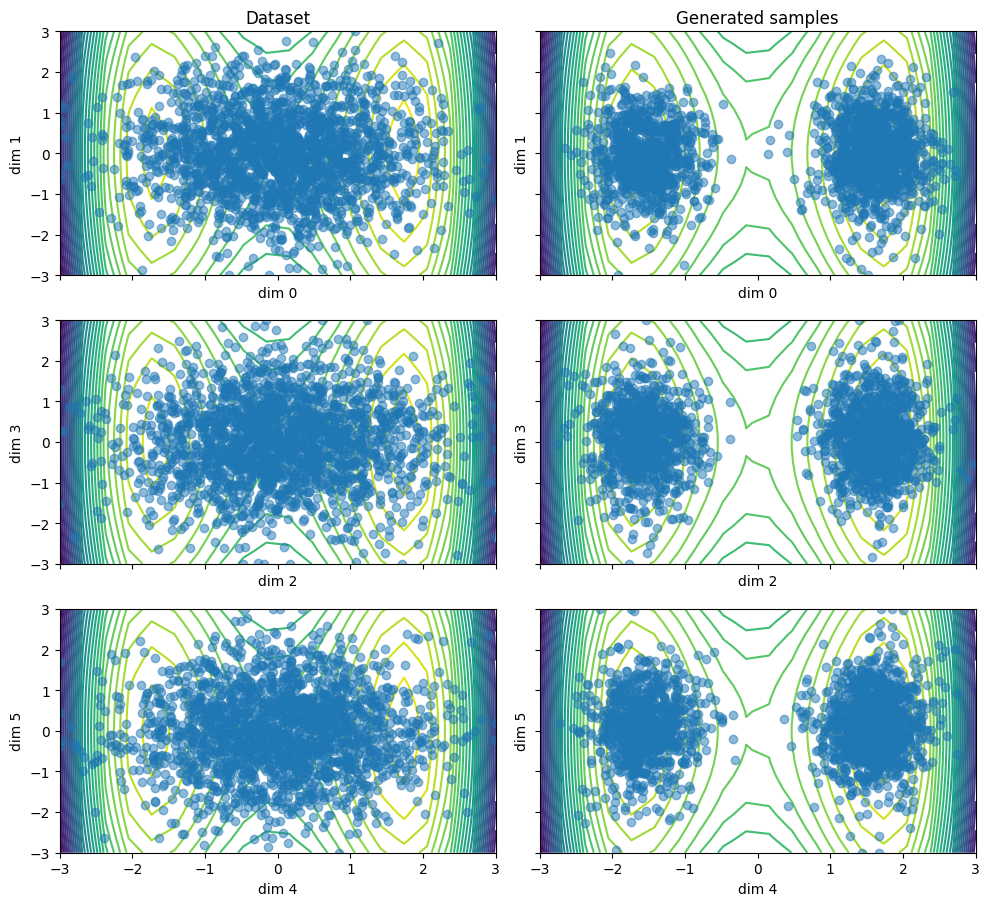

  1%|          | 1/100 [00:27<46:01, 27.90s/it]

Epoch 0 | Loss 1036.717651
Epoch 49 | Loss 376.824097


  1%|          | 1/100 [00:37<1:01:48, 37.46s/it]


KeyboardInterrupt: 

In [23]:
outer_epochs= 100
inner_epochs = 100

num_samples = 2048 

train_dataset = TensorDataset(init_samples.clone(), init_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True) 
global_mins, global_maxs = global_mins_init, global_maxs_init


for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            opt_vectorfield.zero_grad()
            # t = torch.rand(len(samples), device=device)

            low_time_t = (-0.1 * torch.rand(len(samples), device=device)) + 0.1
            high_time_t = (-0.9 * torch.rand(len(samples), device=device)) + 1.0
            
            mask = torch.rand(len(samples), device=device) < 0.8
            
            t = (low_time_t * mask) + (high_time_t * ~mask)

            loss = reward_matching_loss_biased(vectorfield, samples, t, beta)
            total_loss += loss.item()
            loss.backward()
            opt_vectorfield.step()
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the vector field
    ve_reverse_sde = VEReverseSDE(vectorfield, beta)
    samples = generate_samples(ve_reverse_sde, init_samples)[-1]
    samples_energy = target.log_prob(unnormalize(samples, global_mins, global_maxs)).detach()

    # Update Buffer 
    buffer.add(samples, samples_energy)

    plot_dataset(unnormalize(train_dataset.tensors[0], global_mins, global_maxs), 
                 unnormalize(samples, global_mins, global_maxs))
    plt.show()
    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(512 * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True)